## Imports

In [2]:
import torch
import pandas as pd
import numpy as np
import transformers
from datasets import load_dataset, load_metric, Dataset
from lion_pytorch import Lion
from peft import LoraConfig, TaskType, get_peft_model
from transformers.optimization import get_cosine_schedule_with_warmup


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/fropych/anaconda3/envs/env/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda121.so
CUDA SETUP: CUDA runtime path found: /home/fropych/anaconda3/envs/env/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 121
CUDA SETUP: Loading binary /home/fropych/anaconda3/envs/env/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda121.so...


In [1]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'

## Model and training

In [3]:
metric = load_metric("f1")
def compute_metrics(eval_pred, return_t=False):
    """
    This function takes a tuple of logits and labels as input and returns the f1 score of the predictions. 
    If return_t=True, it also returns the best threshold value and the f1 score.
    
    Args:
    - eval_pred: A tuple of logits and labels
    - return_t: A boolean flag indicating whether to return the best threshold value and the f1 score
    
    Returns:
    - output: A dictionary containing the f1 score of the predictions.
    - If return_t=True, returns a tuple containing the best threshold value and the f1 score.
    """
    logits, labels = eval_pred
    predictions = torch.tensor(logits, dtype=torch.float32).numpy()
    best_t = [0, 0]
    for t in np.arange(0., 1., 0.01):
      preds =  predictions > t
      preds = preds.astype(int)
      score = metric.compute(predictions=preds, references=labels)['f1']
      if score > best_t[0]:
        best_t[0] = score
        best_t[1] = t
    
    t = best_t[1]
    output = metric.compute(predictions=(predictions>best_t[1]).astype(int), references=labels)
        
    if return_t:
      return t, output
    return output

/tmp/ipykernel_1585/1310002194.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")
/home/fropych/anaconda3/envs/env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
MODEL_NAME = "sberbank-ai/ruRoberta-large"
DEVICE = 'cuda'
BATCH_SIZE = 16
SEED = 4211
MODEL_MAX_LENGTH = 150

In [31]:
id2label = {0: "hu_answer", 1: "ai_answer"}
label2id = {"hu_answer": 0, "ai_answer": 1}
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=1,
)

Some weights of the model checkpoint at sberbank-ai/ruRoberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_

In [6]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.truncation_side = 'right'
tokenizer.model_max_length = MODEL_MAX_LENGTH

In [7]:
train = load_dataset('csv', data_files={'train': TRAIN_PATH})['train']
train = train.shuffle(seed=SEED)

Found cached dataset csv (/home/fropych/.cache/huggingface/datasets/csv/default-76067d4368fbe73e/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/fropych/.cache/huggingface/datasets/csv/default-76067d4368fbe73e/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-e13c4bead7d925ff.arrow


In [8]:
def concat(examples):
    """
    Concatenates question titles and answer texts to form inputs.

    Args:
    - examples (dict): A dictionary containing 'q_title' and 'ans_text' keys.

    Returns:
    - A dictionary with a single 'text' key containing the concatenated inputs.
    """
    inputs = [f"{answer}" for context, answer in zip(examples['q_title'], examples['ans_text'])]
    return {"text": inputs}


def tokenize(examples):
    """
    Tokenizes the inputs using the tokenizer.

    Args:
    - examples (dict): A dictionary containing 'text' and 'label' keys.

    Returns:
    - A dictionary with tokenized inputs and labels.
    """
    outputs = tokenizer(
        examples["text"],
        truncation=True,
        max_length=MODEL_MAX_LENGTH,
    )

    outputs["labels"] = [float(label2id[x]) for x in examples["label"]]
    return outputs


tokenized_datasets = (
    train
    .map(concat, batched=True)
    .map(tokenize, batched=True, remove_columns=[x for x in train.column_names])
)

Loading cached processed dataset at /home/fropych/.cache/huggingface/datasets/csv/default-76067d4368fbe73e/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-905ecdc6868e2082.arrow
Loading cached processed dataset at /home/fropych/.cache/huggingface/datasets/csv/default-76067d4368fbe73e/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-fd22573e98043302.arrow


In [9]:
tokenized_datasets = tokenized_datasets.train_test_split(0.2)
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

In [16]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.20,
    target_modules = ['query', 'key', 'value'],
    modules_to_save=['classifier']
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 4460546 || all params: 358770690 || trainable%: 1.2432860666516543


In [34]:
from transformers import DataCollatorWithPadding

n_epochs = 8

optim = Lion(model.parameters(), lr=2e-5, weight_decay=1.)
scheduler = get_cosine_schedule_with_warmup(
    optim,
    num_training_steps=n_epochs*train_dataset.num_rows//BATCH_SIZE,
    num_warmup_steps=100
)

trainer = transformers.Trainer(
    model=model,
    optimizers=[optim, scheduler],
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        evaluation_strategy="epoch",
        gradient_accumulation_steps=1,
        num_train_epochs=n_epochs,
        weight_decay=1.,
        learning_rate=2e-5,
        fp16=True,
        logging_steps=100,
        output_dir="outputs",
        save_steps=100000,
    ),
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, ),
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
)
model.config.use_cache = False
trainer.train()


In [23]:
model.save_pretrained('models/lora3')

In [32]:
from peft import PeftModel, PeftConfig

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=1,
)
config = PeftConfig.from_pretrained('models/lora1')
peft_model = PeftModel.from_pretrained(model, 'models/lora1').to('cuda')
peft_model.eval()

Some weights of the model checkpoint at sberbank-ai/ruRoberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-23): 24 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(
                    in_features=1024, out_features=1024, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                

In [33]:
trainer.model = peft_model

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 trainer.model = peft_model                                                                   │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

In [35]:
preds = trainer.predict(train_dataset)

  0%|          | 0/241 [00:00<?, ?it/s]

In [27]:
t, m = compute_metrics((preds.predictions, np.array(test_dataset['labels'], dtype=int)) , True)

In [28]:
t, m

(0.8, {'f1': 0.9968520461699895})

In [11]:
peft_model.base_model.model.classifier = torch.nn.Sequential()

In [25]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, )

def collate_fn(batch):
    return data_collator({'input_ids': [batch[i]['input_ids'] for i in range(len(batch))]})

dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

outp = []

peft_model.eval()
with torch.no_grad():
    for x in tqdm(dl):
        outp.extend(peft_model(x['input_ids'].to('cuda'), x['attention_mask'].to('cuda')).logits[:, 0].cpu().tolist())

100%|██████████| 241/241 [00:53<00:00,  4.51it/s]


## Visualization

In [27]:
embeds = np.array(outp)

<AxesSubplot: >

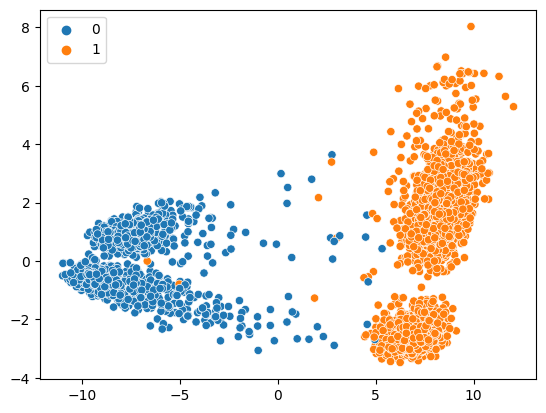

In [30]:
import seaborn as sns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(embeds)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=np.array(train_dataset['labels']).astype(int));